# EDA and Preprocessing
## Starting dataset: S&P Index over the past 5 years

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# reading in the data:
df = pd.read_csv('../data/^GSPC.csv')
print(df.head())
print(df.tail())

         Date         Open         High          Low        Close  \
0  2015-10-12  2015.650024  2018.660034  2010.550049  2017.459961   
1  2015-10-13  2015.000000  2022.339966  2001.780029  2003.689941   
2  2015-10-14  2003.660034  2009.560059  1990.729980  1994.239990   
3  2015-10-15  1996.469971  2024.150024  1996.469971  2023.859985   
4  2015-10-16  2024.369995  2033.540039  2020.459961  2033.109985   

     Adj Close      Volume  
0  2017.459961  2893250000  
1  2003.689941  3401920000  
2  1994.239990  3644590000  
3  2023.859985  3746290000  
4  2033.109985  3595430000  
            Date         Open         High          Low        Close  \
1254  2020-10-05  3367.270020  3409.570068  3367.270020  3408.600098   
1255  2020-10-06  3408.739990  3431.560059  3354.540039  3360.969971   
1256  2020-10-07  3384.560059  3426.260010  3384.560059  3419.439941   
1257  2020-10-08  3434.280029  3447.280029  3428.149902  3446.830078   
1258  2020-10-09  3459.669922  3482.340088  3458.07

### Adding features of 50 and 100 day moving average adjusted closing price

In [110]:
# we calculate the moving averages using the .rolling function from pandas
# --> we keep center=False so these have NaNs for the first 49 and 99 entries
moving_avg_50 = df['Adj Close'].rolling(window=50,center=False).mean()
moving_avg_100 = df['Adj Close'].rolling(window=100,center=False).mean()

In [111]:
moving_avg_50

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
           ...     
1254    3365.464209
1255    3367.895410
1256    3371.915410
1257    3375.683213
1258    3380.301611
Name: Adj Close, Length: 1259, dtype: float64

In [112]:
# ... and we attach these features to our dataframe:
df['moving_avg_50'] = moving_avg_50
df['moving_avg_100'] = moving_avg_100

print(df.tail())

            Date         Open         High          Low        Close  \
1254  2020-10-05  3367.270020  3409.570068  3367.270020  3408.600098   
1255  2020-10-06  3408.739990  3431.560059  3354.540039  3360.969971   
1256  2020-10-07  3384.560059  3426.260010  3384.560059  3419.439941   
1257  2020-10-08  3434.280029  3447.280029  3428.149902  3446.830078   
1258  2020-10-09  3459.669922  3482.340088  3458.070068  3477.139893   

        Adj Close      Volume  moving_avg_50  moving_avg_100  
1254  3408.600098  3686920000    3365.464209     3234.803010  
1255  3360.969971  4443380000    3367.895410     3239.887710  
1256  3419.439941  3807830000    3371.915410     3245.445110  
1257  3446.830078  3856190000    3375.683213     3250.374312  
1258  3477.139893  3939060000    3380.301611     3255.916311  


### To avoid missing values in the 50- and 100-day rolling average column, we'll fill the missing values with the cumulative averages over the first d<50,100 days (i.e. for day 10, the value will be the average over the first 9 days)
***we'll necessarily still have NaN in the first day's slot because we have no previous days Adj. Close to look at, but we can just drop the first row***

In [113]:
# expanding().mean() gives us the cumulative average
cumulative_avg = df['Adj Close'].expanding().mean()

In [114]:
# loop through the 2nd through 49th elements of the 50-day moving
# average column and fill in the cumulative average values
for i in range(1,49):
    df['moving_avg_50'].iloc[i] = cumulative_avg[i-1]
    
# ... and then the same for the 2nd through 99th elements of the 100-day
for i in range(1,99):
    df['moving_avg_100'].iloc[i] = cumulative_avg[i-1]

/opt/anaconda3/envs/data1030/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


### Adding date-related features

In [115]:
# we'll need to parse the Date column into datetime objects to easy operate on their values?
import datetime

In [116]:
# example look at the types of date in the dataframe
d = df['Date'][0]
print(d)
print(type(d))
date_time_obj = datetime.datetime.strptime(d, '%Y-%m-%d').date()
print(date_time_obj)
print(type(date_time_obj))

2015-10-12
<class 'str'>
2015-10-12
<class 'datetime.date'>


In [117]:
dates = pd.Series([datetime.datetime.strptime(dt, '%Y-%m-%d').date() for dt in list(df['Date'])])

In [118]:
# and now we reassign our Date column to be this series we've created with datetime objects
df['Date'] = dates

In [119]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,moving_avg_50,moving_avg_100
0,2015-10-12,2015.650024,2018.660034,2010.550049,2017.459961,2017.459961,2893250000,NaN,NaN
1,2015-10-13,2015.000000,2022.339966,2001.780029,2003.689941,2003.689941,3401920000,2017.459961,2017.459961
2,2015-10-14,2003.660034,2009.560059,1990.729980,1994.239990,1994.239990,3644590000,2010.574951,2010.574951
3,2015-10-15,1996.469971,2024.150024,1996.469971,2023.859985,2023.859985,3746290000,2005.129964,2005.129964
4,2015-10-16,2024.369995,2033.540039,2020.459961,2033.109985,2033.109985,3595430000,2009.812469,2009.812469


#### We want to add features for month number (account for seasonal trends), day in year (for quarterly trends), days until nearest election (for election-related trends)

In [120]:
# using datetime to get the month from a date
d = df['Date'][0]
print(type(d))
print(d.month)
print(type(d.month))

# using datetime to get number of day in the year
day_of_year = d.timetuple().tm_yday
print(day_of_year)

test_day = datetime.datetime.strptime('2016-1-1', '%Y-%m-%d').date()
print(test_day.timetuple().tm_yday)

<class 'datetime.date'>
10
<class 'int'>
285
1


In [121]:
# add these features to the dataframe:
month = pd.Series([d.month for d in df['Date']])
day = pd.Series([d.timetuple().tm_yday for d in df['Date']])

df['Month'] = month
df['Day'] = day

In [122]:
print(df.head())

         Date         Open         High          Low        Close  \
0  2015-10-12  2015.650024  2018.660034  2010.550049  2017.459961   
1  2015-10-13  2015.000000  2022.339966  2001.780029  2003.689941   
2  2015-10-14  2003.660034  2009.560059  1990.729980  1994.239990   
3  2015-10-15  1996.469971  2024.150024  1996.469971  2023.859985   
4  2015-10-16  2024.369995  2033.540039  2020.459961  2033.109985   

     Adj Close      Volume  moving_avg_50  moving_avg_100  Month  Day  
0  2017.459961  2893250000            NaN             NaN     10  285  
1  2003.689941  3401920000    2017.459961     2017.459961     10  286  
2  1994.239990  3644590000    2010.574951     2010.574951     10  287  
3  2023.859985  3746290000    2005.129964     2005.129964     10  288  
4  2033.109985  3595430000    2009.812469     2009.812469     10  289  


In [123]:
# time come up with days from nearest election we'll hardcode the three election dates that
# surround any point in this 5-year window:
e1 = datetime.datetime.strptime('2012-11-6', '%Y-%m-%d').date()
e2 = datetime.datetime.strptime('2016-11-8', '%Y-%m-%d').date()
e3 = datetime.datetime.strptime('2020-11-3', '%Y-%m-%d').date()

In [124]:
# ... and for each day we want the number of days until the nearest election
# ----> for five days before the value would be 5, and forr five days after the
# value would be -5. This will give us the ability to measure distance from election
# while still distinguishing between a date being before or after an election

# For election date e and date d, this will be expressed as e-d for e-d with the minimum absolute value
# between the three measures (|e1-d|, |e2-d|, |e3-d|)

# quick look at taking the difference of datetime objects:
d1 = df['Date'][0]
d2 = df['Date'][1]
diff = d1-d2
print(diff.days)
print(type(diff.days))

-1
<class 'int'>


In [125]:
# for day d1 the operation looks like this:
pairs = [(e1,d1),(e2,d1),(e3,d1)]
closest = min(pairs, key=lambda x: np.abs((x[0]-x[1]).days))
print((closest[0]-closest[1]).days)

393


In [126]:
# we'll create this feature by iterating through our date feature and calculating this element-wise
days_to_election = []
for d in df['Date']:
    pairs = [(e1,d),(e2,d),(e3,d)]
    closest = min(pairs, key=lambda x: np.abs((x[0]-x[1]).days))
    diff = (closest[0]-closest[1]).days
    days_to_election.append(diff)
    
days_to_election = pd.Series(days_to_election)

In [127]:
df['Days_to_election'] = days_to_election

In [128]:
print(df['Days_to_election'].head())
print(df['Days_to_election'].tail())

0    393
1    392
2    391
3    390
4    389
Name: Days_to_election, dtype: int64
1254    29
1255    28
1256    27
1257    26
1258    25
Name: Days_to_election, dtype: int64


### Now we'll add some weather related data
#### We're getting this data from a NOAA dataset describing the average temperature (in Farenheit) in each month from 2015-2020, as well as the departure from from the mean (relative to month)

In [129]:
# using skiprows parameter to skip the documentation info in the csv
wthr = pd.read_csv('../data/110-tavg-all-9-2015-2020.csv', skiprows=4)
print(wthr.head())
print(wthr.tail())

     Date  Value  Anomaly
0  201501  33.08    -0.11
1  201502  32.99    -3.20
2  201503  45.39     0.70
3  201504  53.24     1.08
4  201505  60.84    -0.43
      Date  Value  Anomaly
64  202005  60.87    -0.40
65  202006  70.29    -0.39
66  202007  75.65     0.56
67  202008  74.71     1.30
68  202009  65.98    -1.33


In [130]:
# we'll add this to out dataset by giving each monthly value for each day in that month
# ----> additionally we need to cut off the months before october 2015, and because this
# ----> only has data through september 2020, we will extend that value into october 2020

In [131]:
# for each point in our dataset, we'll get our corresponding weather values in 'Value' and
# 'Anomaly' in the YYYYMM row
# ---> we'll traverse through and populate these lists
vals = []
anom = []
for date in df['Date']:
    # the wthr dataset stores the dataset as ints of the form:
    yr = str(date.year)
    mn = str(date.month)
    # prepend a zero if necessry
    if len(mn)<2:
        mn = '0'+mn
    date_int = int(yr+mn)
    
    v = list(wthr.loc[wthr['Date'] == date_int]['Value'])
    if len(v)>0:
        vals.append(v[0])
    else: # we get an error when we try to get data for 2020-10, so we'll grab from 2020-9 there
        sept = 202009
        vals.append(list(wthr.loc[wthr['Date'] == sept]['Value'])[0])

    a = list(wthr.loc[wthr['Date'] == date_int]['Anomaly'])
    if len(a)>0:
        anom.append(a[0])
    else:
        sept = 202009
        anom.append(list(wthr.loc[wthr['Date'] == sept]['Anomaly'])[0])


In [132]:
print(len(anom))
print(len(vals))
print(anom[0])
print(vals[0])

1259
1259
1.96
57.24


In [133]:
# adding these features to the dataset
df['Avg_month_temp'] = pd.Series(vals)
df['Avg_month_temp_dev'] = pd.Series(anom)

In [134]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,moving_avg_50,moving_avg_100,Month,Day,Days_to_election,Avg_month_temp,Avg_month_temp_dev
1254,2020-10-05,3367.270020,3409.570068,3367.270020,3408.600098,3408.600098,3686920000,3365.464209,3234.803010,10,279,29,65.98,-1.33
1255,2020-10-06,3408.739990,3431.560059,3354.540039,3360.969971,3360.969971,4443380000,3367.895410,3239.887710,10,280,28,65.98,-1.33
1256,2020-10-07,3384.560059,3426.260010,3384.560059,3419.439941,3419.439941,3807830000,3371.915410,3245.445110,10,281,27,65.98,-1.33
1257,2020-10-08,3434.280029,3447.280029,3428.149902,3446.830078,3446.830078,3856190000,3375.683213,3250.374312,10,282,26,65.98,-1.33
1258,2020-10-09,3459.669922,3482.340088,3458.070068,3477.139893,3477.139893,3939060000,3380.301611,3255.916311,10,283,25,65.98,-1.33


### Adding a consumer confidence index from the OECD
#### From source: "An indicator above 100 signals a boost in the consumers’ confidence towards the future economic situation, as a consequence of which they are less prone to save, and more inclined to spend money on major purchases in the next 12 months. Values below 100 indicate a pessimistic attitude towards future developments in the economy, possibly resulting in a tendency to save more and consume less."

In [135]:
cci = pd.read_csv('../data/DP_LIVE_13102020153116484.csv')
# ... and this dataset has international data so we'll pick out the USA data
consumer_sent = cci.loc[cci['LOCATION'] == 'USA']
print(consumer_sent.head())
print(consumer_sent.tail())

     LOCATION INDICATOR   SUBJECT    MEASURE FREQUENCY     TIME     Value  \
1051      USA       CCI  AMPLITUD  LTRENDIDX         M  2014-01  99.25951   
1052      USA       CCI  AMPLITUD  LTRENDIDX         M  2014-02  99.33441   
1053      USA       CCI  AMPLITUD  LTRENDIDX         M  2014-03  99.36888   
1054      USA       CCI  AMPLITUD  LTRENDIDX         M  2014-04  99.44692   
1055      USA       CCI  AMPLITUD  LTRENDIDX         M  2014-05  99.43237   

      Flag Codes  
1051         NaN  
1052         NaN  
1053         NaN  
1054         NaN  
1055         NaN  
     LOCATION INDICATOR   SUBJECT    MEASURE FREQUENCY     TIME     Value  \
1127      USA       CCI  AMPLITUD  LTRENDIDX         M  2020-05  98.44251   
1128      USA       CCI  AMPLITUD  LTRENDIDX         M  2020-06  98.37772   
1129      USA       CCI  AMPLITUD  LTRENDIDX         M  2020-07  98.36588   
1130      USA       CCI  AMPLITUD  LTRENDIDX         M  2020-08  98.53522   
1131      USA       CCI  AMPLITUD  LTR

In [136]:
# and once again we have monthly data with string dates so let's traverse through
# our financial dataset grabbing the month's values we want
# ----> NB: we're missing 2020-10 again so we have to handle that individually
type(list(consumer_sent['TIME'])[10])

str

In [137]:
list(consumer_sent['TIME'])[-1]

'2020-09'

In [138]:
consumer_ind = []

for date in df['Date']:
    # the wthr dataset stores the dataset as ints of the form:
    yr = str(date.year)
    mn = str(date.month)
    
    date_str = yr+'-'+mn
    
    ci = list(consumer_sent.loc[consumer_sent['TIME'] == date_str]['Value'])
    if len(ci)>0:
        consumer_ind.append(ci[0])
    else: # we get an error when we try to get data for 2020-10, so we'll grab from 2020-9 there
        sept = '2020-09'
        consumer_ind.append(list(consumer_sent.loc[consumer_sent['TIME'] == sept]['Value'])[0])

In [139]:
# add this to the dataset
df['CCI'] = pd.Series(consumer_ind)

In [140]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,moving_avg_50,moving_avg_100,Month,Day,Days_to_election,Avg_month_temp,Avg_month_temp_dev,CCI
1254,2020-10-05,3367.270020,3409.570068,3367.270020,3408.600098,3408.600098,3686920000,3365.464209,3234.803010,10,279,29,65.98,-1.33,98.85777
1255,2020-10-06,3408.739990,3431.560059,3354.540039,3360.969971,3360.969971,4443380000,3367.895410,3239.887710,10,280,28,65.98,-1.33,98.85777
1256,2020-10-07,3384.560059,3426.260010,3384.560059,3419.439941,3419.439941,3807830000,3371.915410,3245.445110,10,281,27,65.98,-1.33,98.85777
1257,2020-10-08,3434.280029,3447.280029,3428.149902,3446.830078,3446.830078,3856190000,3375.683213,3250.374312,10,282,26,65.98,-1.33,98.85777
1258,2020-10-09,3459.669922,3482.340088,3458.070068,3477.139893,3477.139893,3939060000,3380.301611,3255.916311,10,283,25,65.98,-1.33,98.85777


### Lastly, we'll add a volatility index from FRED
#### which "measures market expectation of near term volatility conveyed by stock index option prices"

#### NB: (there are missing values in this data but they only occur on dates not in our S&P data)

In [141]:
# we were able to download by specific date range so this is alreay cut to the same date range and the S&P data
vix = pd.read_csv('../data/VIXCLS.csv')
print(vix.head())

         DATE VIXCLS
0  2015-10-12  16.17
1  2015-10-13  17.67
2  2015-10-14  18.03
3  2015-10-15  16.05
4  2015-10-16  15.05


In [142]:
# ... with string date types
type(vix['DATE'][0])

str

In [143]:
# cast the dates to datetime so we can do a left join on the dates in the main dataset:
dates = pd.Series([datetime.datetime.strptime(dt, '%Y-%m-%d').date() for dt in list(vix['DATE'])])
vix['DATE'] = dates

In [144]:
print(vix.head())

         DATE VIXCLS
0  2015-10-12  16.17
1  2015-10-13  17.67
2  2015-10-14  18.03
3  2015-10-15  16.05
4  2015-10-16  15.05


In [145]:
df = df.merge(vix,how='left',left_on='Date',right_on='DATE')

In [146]:
# VIXCLS goes in as a string so we'll now cast that to a series of floats
print(type(df['VIXCLS'][0]))

<class 'str'>


In [147]:
# go into the df and switch VIX out for its float casted series
df['VIXCLS'] = df['VIXCLS'].astype('float')

In [148]:
# check that it stuck
print(type(df['VIXCLS'][0]))

<class 'numpy.float64'>


In [149]:
# and we can get rid of the duplicate DATE column from the volatility data:
df = df.drop(columns=['DATE'])

In [150]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,moving_avg_50,moving_avg_100,Month,Day,Days_to_election,Avg_month_temp,Avg_month_temp_dev,CCI,VIXCLS
1254,2020-10-05,3367.270020,3409.570068,3367.270020,3408.600098,3408.600098,3686920000,3365.464209,3234.803010,10,279,29,65.98,-1.33,98.85777,27.96
1255,2020-10-06,3408.739990,3431.560059,3354.540039,3360.969971,3360.969971,4443380000,3367.895410,3239.887710,10,280,28,65.98,-1.33,98.85777,29.48
1256,2020-10-07,3384.560059,3426.260010,3384.560059,3419.439941,3419.439941,3807830000,3371.915410,3245.445110,10,281,27,65.98,-1.33,98.85777,28.06
1257,2020-10-08,3434.280029,3447.280029,3428.149902,3446.830078,3446.830078,3856190000,3375.683213,3250.374312,10,282,26,65.98,-1.33,98.85777,26.36
1258,2020-10-09,3459.669922,3482.340088,3458.070068,3477.139893,3477.139893,3939060000,3380.301611,3255.916311,10,283,25,65.98,-1.33,98.85777,25.00


#### Quick check below that our new volatility column doesn't have any missing values

In [151]:
# now to deal with the missing values -- I believe they're just "."?
vix.loc[vix['VIXCLS'] == '.'].head()

,DATE,VIXCLS
33,2015-11-26,.
54,2015-12-25,.
59,2016-01-01,.
70,2016-01-18,.
90,2016-02-15,.


In [152]:
'.' in list(df['VIXCLS'])

False

In [153]:
print(len(vix))
print(len(df))
print(len(vix.loc[vix['VIXCLS'] == '.']))

1305
1259
46


### Total dataset before preprocessing/normalization:

In [154]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,moving_avg_50,moving_avg_100,Month,Day,Days_to_election,Avg_month_temp,Avg_month_temp_dev,CCI,VIXCLS
0,2015-10-12,2015.650024,2018.660034,2010.550049,2017.459961,2017.459961,2893250000,NaN,NaN,10,285,393,57.24,1.96,100.39440,16.17
1,2015-10-13,2015.000000,2022.339966,2001.780029,2003.689941,2003.689941,3401920000,2017.459961,2017.459961,10,286,392,57.24,1.96,100.39440,17.67
2,2015-10-14,2003.660034,2009.560059,1990.729980,1994.239990,1994.239990,3644590000,2010.574951,2010.574951,10,287,391,57.24,1.96,100.39440,18.03
3,2015-10-15,1996.469971,2024.150024,1996.469971,2023.859985,2023.859985,3746290000,2005.129964,2005.129964,10,288,390,57.24,1.96,100.39440,16.05
4,2015-10-16,2024.369995,2033.540039,2020.459961,2033.109985,2033.109985,3595430000,2009.812469,2009.812469,10,289,389,57.24,1.96,100.39440,15.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,2020-10-05,3367.270020,3409.570068,3367.270020,3408.600098,3408.600098,3686920000,3365.464209,3234.803010,10,279,29,65.98,-1.33,98.85777,27.96
1255,2020-10-06,3408.739990,3431.560059,3354.540039,3360.969971,3360.969971,4443380000,3367.895410,3239.887710,10,280,28,65.98,-1.33,98.85777,29.48
1256,2020-10-07,3384.560059,3426.260010,3384.560059,3419.439941,3419.439941,3807830000,3371.915410,3245.445110,10,281,27,65.98,-1.33,98.85777,28.06
1257,2020-10-08,3434.280029,3447.280029,3428.149902,3446.830078,3446.830078,3856190000,3375.683213,3250.374312,10,282,26,65.98,-1.33,98.85777,26.36


### The features we have in this dataset:

In [155]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'moving_avg_50', 'moving_avg_100', 'Month', 'Day', 'Days_to_election',
       'Avg_month_temp', 'Avg_month_temp_dev', 'CCI', 'VIXCLS'],
      dtype='object')

## EDA

In [156]:
# below are the .describe() outputs for the continuous columns
for col in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'moving_avg_50', 'moving_avg_100', 'Day', 'Days_to_election',
       'Avg_month_temp', 'Avg_month_temp_dev', 'CCI', 'VIXCLS']:
    print("DISTRIBUTION FOR COLUMN: ",col)
    print(df[col].describe())

DISTRIBUTION FOR COLUMN:  Open
count    1259.000000
mean     2616.053343
std       396.428545
min      1833.400024
25%      2269.429932
50%      2660.629883
75%      2898.220093
max      3564.739990
Name: Open, dtype: float64
DISTRIBUTION FOR COLUMN:  High
count    1259.000000
mean     2628.914567
std       398.723324
min      1847.000000
25%      2274.825073
50%      2679.629883
75%      2907.940064
max      3588.110107
Name: High, dtype: float64
DISTRIBUTION FOR COLUMN:  Low
count    1259.000000
mean     2601.677776
std       393.922986
min      1810.099976
25%      2263.335083
50%      2647.320068
75%      2881.989990
max      3535.229980
Name: Low, dtype: float64
DISTRIBUTION FOR COLUMN:  Close
count    1259.000000
mean     2616.353596
std       396.369718
min      1829.079956
25%      2269.719971
50%      2662.850098
75%      2892.189941
max      3580.840088
Name: Close, dtype: float64
DISTRIBUTION FOR COLUMN:  Adj Close
count    1259.000000
mean     2616.353596
std       396.3697

In [157]:
# and here are the value counts for the categorical features -- this is just month
for col in ['Month']:
    print('VALUE COUNTS FOR COLUMN: ',col)
    print(df[col].value_counts())

VALUE COUNTS FOR COLUMN:  Month
8     112
10    111
3     109
6     107
5     107
7     105
12    103
11    103
4     103
1     102
9     101
2      96
Name: Month, dtype: int64


### quick look at a few single-feature plots:

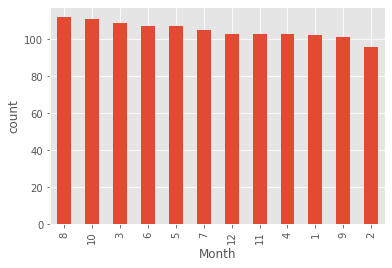

In [158]:
# HISTOGRAM OF POINTS FOR EACH MONTH
pd.value_counts(df['Month']).plot.bar()
plt.ylabel('count')
plt.xlabel('Month')
plt.show()

#### this shows that we have exactly the distribution we would expect across each month (each count is 5 times the number of business days in each month)

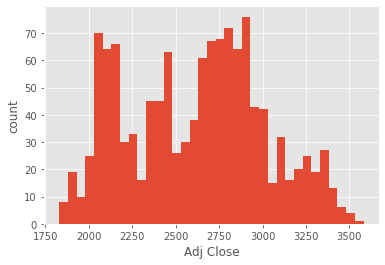

In [159]:
# HISTOGRAM OF ADJUSTED CLOSE PRICE
df['Adj Close'].plot.hist(bins = int(np.sqrt(df.shape[0]))) 
plt.xlabel('Adj Close')
plt.ylabel('count')
plt.show()

#### This gives us a rough look at the distribution of our target variable and we can see a couple of modes in the middle of the distribution

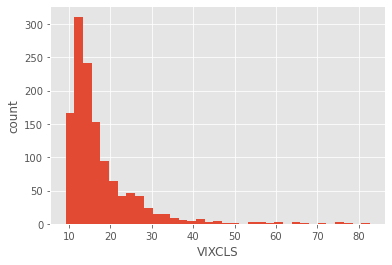

In [160]:
# HISTOGRAM OF VOLATILITY
df['VIXCLS'].plot.hist(bins = int(np.sqrt(df.shape[0]))) 
plt.xlabel('VIXCLS')
plt.ylabel('count')
plt.show()

#### We see that our volatility follows a long-tailed distribution at the upper end and is very focused on the lower end

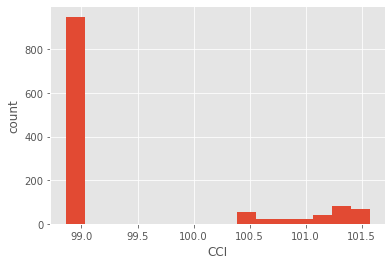

In [161]:
# HISTOGRAM OF CONSUMER CONFIDENCE
df['CCI'].plot.hist(bins = df['CCI'].nunique()) 
plt.xlabel('CCI')
plt.ylabel('count')
plt.show()

#### We see here that most values fall just below 99.0 with a sort of upper tail signifying higher confidence

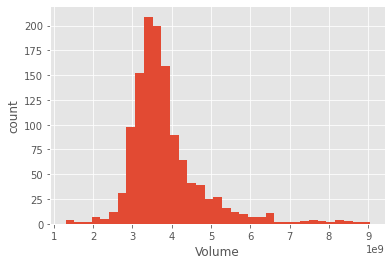

In [162]:
# HISTOGRAM OF VOLUME
df['Volume'].plot.hist(bins = int(np.sqrt(df.shape[0]))) 
plt.xlabel('Volume')
plt.ylabel('count')
plt.show()

#### This shows us that volume follows a very neat distribution centered around 3.8e9 with a longer upper tail than lower tail. Additionally because the scale is so large on this variable we have extra motivation to apply a standard scaler

### Plotting features against each other

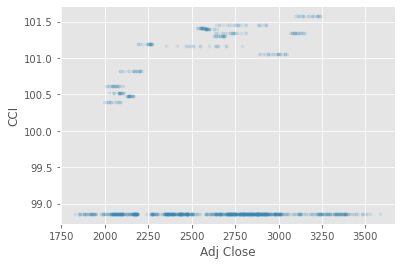

In [163]:
df.plot.scatter('Adj Close','CCI',s=10,alpha=0.1) # alpha=0.1,s=10
plt.show()

#### This shows some correllation with high consumer confidence and high adjusted close price. There is a some skewing due to the focus of consumer confidence on a value just below 99.0

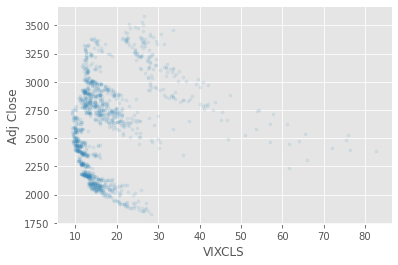

In [164]:
df.plot.scatter('VIXCLS','Adj Close',s=10,alpha=0.1) # alpha=0.1,s=10
plt.show()

#### The relation between volatility and adjusted closing price is not completely clear but we see a few distinct clusters in which higher volatility corresponds with a lower adjusted closing price

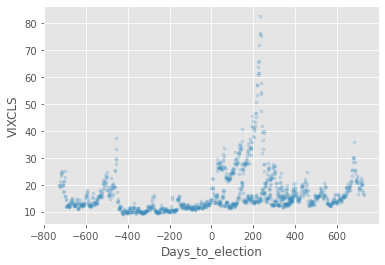

In [165]:
df.plot.scatter('Days_to_election','VIXCLS',s=10,alpha=0.2)
plt.show()

#### The relation between the number of days until the nearest election and volatility shows some periodicity, with a couple of distinct spikes, the largest of which coming 200 days before the nearest election.

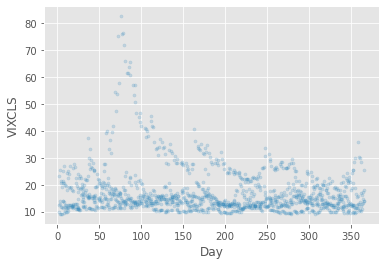

In [166]:
df.plot.scatter('Day','VIXCLS',s=10,alpha=0.2)
plt.show()

#### The relationship between day number and volatility shows some periodicity, with a large spike around day 75 (this could be the result of a tendency of people to invest more at the end of each year's first fiscal quarter)

/opt/anaconda3/envs/data1030/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


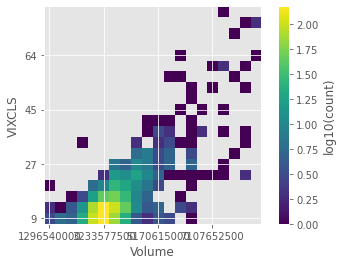

In [167]:
nbins = 20

heatmap, xedges, yedges = np.histogram2d(df['Volume'], df['VIXCLS'], bins=nbins)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.imshow(np.log10(heatmap).T, origin='lower') # use log count
plt.xlabel('Volume')
plt.ylabel('VIXCLS')
plt.xticks(np.arange(nbins)[::int(nbins/4)],xedges[::int(nbins/4)].astype(int))
plt.yticks(np.arange(nbins)[::int(nbins/4)],yedges[::int(nbins/4)].astype(int))
plt.colorbar(label='log10(count)')
plt.show()

#### From this heatmap we see that there is a correllation between volume and volatility, as well as there being a concentration of points around the most common volume. The former makes intuitive sense as possibly representing the entropy that is introduced to the system by an increased number of transactions in the market on a given day.

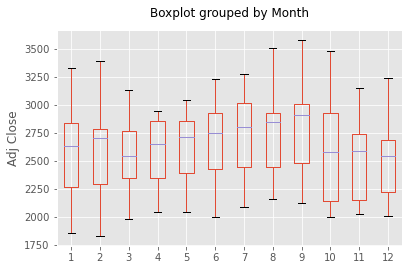

In [168]:
bp = df[['Adj Close','Month']].boxplot(by='Month')
bp.get_figure().gca().set_title("")
bp.get_figure().gca().set_xlabel("")
plt.ylabel('Adj Close')
plt.show()

#### This boxplot shows us the distribution of adjusted closing price in each of the 12 months. This gives a look into possible seasonal trends that might account for the mean and variance of the adjusted closing price varying month to month.

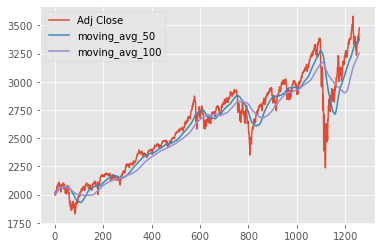

In [169]:
# to use a style that will have a background grid
from matplotlib import style
style.use('ggplot')

# plotting adj close against the two moving averages
prices = df.loc[:, ['Adj Close','moving_avg_50','moving_avg_100']]
prices.plot()

#### Plotting the adjusted closing price against our engineered features of 50- and 100-day moving average gives us an important look at the function of including these rolling averages in our feature matrix. The n-day moving averages provide a way for us to look at a smoothed out version of the target variable, with the size of the window being proportional to the curve's resistance to quick fluctuation.

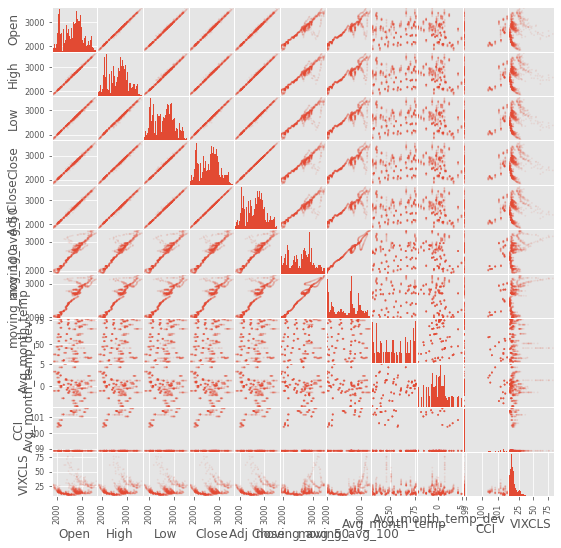

In [170]:
pd.plotting.scatter_matrix(df.select_dtypes(float), figsize=(9, 9), marker='o',hist_kwds={'bins': 50}, 
                           s=3, alpha=.1)
plt.show()

#### Here we have a scatter matrix of all of our float-valued features. In the upper left corner we see there is a very closely linear correllation between the related features from the original dataset (Open, Close, High, Low, Adj Close).

## Preprocessing:
### Making our train/val/test split and standardizing and encoding all features except for the target variable (adjusted close price)

In [171]:
# We'll split out data manually into the data from years [1,2,3], [4], [5] for training, val, and test respectively
# --> in the interest of symmetry, we'll just divide the number of rows by five and divide into fifths that way

num_rows = len(df)
year_rows = num_rows//5

train_inds = list(range(3*year_rows))
val_inds = list(range(3*year_rows, 4*year_rows))
test_inds = list(range(4*year_rows, num_rows))

In [172]:
print('test inds from ',min(train_inds),' to ',max(train_inds))
print('test inds from ',min(val_inds),' to ',max(val_inds))
print('test inds from ',min(test_inds),' to ',max(test_inds))

test inds from  0  to  752
test inds from  753  to  1003
test inds from  1004  to  1258


In [173]:
X_train = df.iloc[train_inds, df.columns != 'Adj Close']
X_val = df.iloc[val_inds, df.columns != 'Adj Close']
X_test = df.iloc[test_inds, df.columns != 'Adj Close']

In [174]:
y_train = df.iloc[train_inds, df.columns == 'Adj Close']
y_val = df.iloc[val_inds, df.columns == 'Adj Close']
y_test = df.iloc[test_inds, df.columns == 'Adj Close']

In [175]:
# and lastly let's remove the date column from our training matrices, because all date-relevant information
# is encoded by the date-related engineered features
X_train = X_train.drop(columns=['Date'])
X_val = X_val.drop(columns=['Date'])
X_test = X_test.drop(columns=['Date'])

In [176]:
X_test

,Open,High,Low,Close,Volume,moving_avg_50,moving_avg_100,Month,Day,Days_to_election,Avg_month_temp,Avg_month_temp_dev,CCI,VIXCLS
1004,2920.399902,2925.469971,2892.659912,2893.060059,3356450000,2938.058799,2928.222200,10,281,392,52.05,-3.23,101.05780,20.28
1005,2911.100098,2929.320068,2907.409912,2919.399902,2726820000,2936.183198,2928.820898,10,282,391,52.05,-3.23,101.05780,18.64
1006,2918.550049,2948.459961,2917.120117,2938.129883,3217250000,2935.338198,2929.799897,10,283,390,52.05,-3.23,101.05780,17.57
1007,2963.070068,2993.280029,2963.070068,2970.270020,3580460000,2935.672397,2930.858997,10,284,389,52.05,-3.23,101.05780,15.58
1008,2965.810059,2972.840088,2962.939941,2966.149902,2557020000,2936.354395,2931.957795,10,287,386,52.05,-3.23,101.05780,14.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,3367.270020,3409.570068,3367.270020,3408.600098,3686920000,3365.464209,3234.803010,10,279,29,65.98,-1.33,98.85777,27.96
1255,3408.739990,3431.560059,3354.540039,3360.969971,4443380000,3367.895410,3239.887710,10,280,28,65.98,-1.33,98.85777,29.48
1256,3384.560059,3426.260010,3384.560059,3419.439941,3807830000,3371.915410,3245.445110,10,281,27,65.98,-1.33,98.85777,28.06
1257,3434.280029,3447.280029,3428.149902,3446.830078,3856190000,3375.683213,3250.374312,10,282,26,65.98,-1.33,98.85777,26.36


### ...and now we will fit_transform to the training data and transform the validation and testing data

In [177]:
# STANDARD SCALER TO BE APPLIED TO:
#     ['Open', 'High', 'Low', 'Close', 'Volume',
#        'moving_avg_50', 'moving_avg_100',
#         'Avg_month_temp', 'Avg_month_temp_dev', 'CCI', 'VIXCLS'
# MIN-MAX SCALER TO BE APPLIED TO:
#     [Day', 'Days_to_election']
# ONE-HOT ENCODER TO BE APPLIED TO:
#     ['Month']

from sklearn.preprocessing import StandardScaler

std_ftrs = ['Open', 'High', 'Low', 'Close', 'Volume',
            'moving_avg_50', 'moving_avg_100','Avg_month_temp',
            'Avg_month_temp_dev', 'CCI', 'VIXCLS']
scaler = StandardScaler()
X_train[std_ftrs] = scaler.fit_transform(X_train[std_ftrs])
X_val[std_ftrs] = scaler.transform(X_val[std_ftrs])
X_test[std_ftrs] = scaler.transform(X_test[std_ftrs])

In [178]:
X_train

,Open,High,Low,Close,Volume,moving_avg_50,moving_avg_100,Month,Day,Days_to_election,Avg_month_temp,Avg_month_temp_dev,CCI,VIXCLS
0,-1.261893,-1.282373,-1.244264,-1.257836,-1.043700,NaN,NaN,10,285,393,0.159902,0.743925,1.104675,0.513011
1,-1.264133,-1.269703,-1.274461,-1.305309,-0.313123,-1.218345,-1.177777,10,286,392,0.159902,0.743925,1.104675,0.890603
2,-1.303205,-1.313705,-1.312510,-1.337888,0.035411,-1.243204,-1.203765,10,287,391,0.159902,0.743925,1.104675,0.981225
3,-1.327979,-1.263471,-1.292745,-1.235772,0.181478,-1.262864,-1.224317,10,288,390,0.159902,0.743925,1.104675,0.482803
4,-1.231848,-1.231140,-1.210141,-1.203882,-0.035195,-1.245957,-1.206643,10,289,389,0.159902,0.743925,1.104675,0.231075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,1.875767,1.879728,1.880024,1.869527,-0.367313,1.862093,1.817391,10,274,-692,-0.082026,-1.140588,2.257253,-0.536696
749,1.867188,1.860309,1.885052,1.865527,-0.313181,1.870502,1.824953,10,275,-693,-0.082026,-1.140588,2.257253,-0.524109
750,1.894373,1.889369,1.891904,1.872699,-0.030484,1.878092,1.832419,10,276,-694,-0.082026,-1.140588,2.257253,-0.634870
751,1.851855,1.820232,1.762988,1.790303,-0.176766,1.882102,1.838891,10,277,-695,-0.082026,-1.140588,2.257253,0.022141


In [179]:
from sklearn.preprocessing import MinMaxScaler

minmax_ftrs = ['Day', 'Days_to_election']
scaler = MinMaxScaler()
X_train[minmax_ftrs] = scaler.fit_transform(X_train[minmax_ftrs])
X_val[minmax_ftrs] = scaler.transform(X_val[minmax_ftrs])
X_test[minmax_ftrs] = scaler.transform(X_test[minmax_ftrs])

In [180]:
X_train

,Open,High,Low,Close,Volume,moving_avg_50,moving_avg_100,Month,Day,Days_to_election,Avg_month_temp,Avg_month_temp_dev,CCI,VIXCLS
0,-1.261893,-1.282373,-1.244264,-1.257836,-1.043700,NaN,NaN,10,0.779614,1.000000,0.159902,0.743925,1.104675,0.513011
1,-1.264133,-1.269703,-1.274461,-1.305309,-0.313123,-1.218345,-1.177777,10,0.782369,0.999082,0.159902,0.743925,1.104675,0.890603
2,-1.303205,-1.313705,-1.312510,-1.337888,0.035411,-1.243204,-1.203765,10,0.785124,0.998163,0.159902,0.743925,1.104675,0.981225
3,-1.327979,-1.263471,-1.292745,-1.235772,0.181478,-1.262864,-1.224317,10,0.787879,0.997245,0.159902,0.743925,1.104675,0.482803
4,-1.231848,-1.231140,-1.210141,-1.203882,-0.035195,-1.245957,-1.206643,10,0.790634,0.996327,0.159902,0.743925,1.104675,0.231075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,1.875767,1.879728,1.880024,1.869527,-0.367313,1.862093,1.817391,10,0.749311,0.003673,-0.082026,-1.140588,2.257253,-0.536696
749,1.867188,1.860309,1.885052,1.865527,-0.313181,1.870502,1.824953,10,0.752066,0.002755,-0.082026,-1.140588,2.257253,-0.524109
750,1.894373,1.889369,1.891904,1.872699,-0.030484,1.878092,1.832419,10,0.754821,0.001837,-0.082026,-1.140588,2.257253,-0.634870
751,1.851855,1.820232,1.762988,1.790303,-0.176766,1.882102,1.838891,10,0.757576,0.000918,-0.082026,-1.140588,2.257253,0.022141


In [181]:
from sklearn.preprocessing import OneHotEncoder

#initialize and fit the encoder
enc = OneHotEncoder(sparse=False,handle_unknown='ignore')
enc.fit(X_train['Month'].values.reshape(-1,1))
print('feature names:',enc.get_feature_names(['Month']))

feature names: ['Month_1' 'Month_2' 'Month_3' 'Month_4' 'Month_5' 'Month_6' 'Month_7'
 'Month_8' 'Month_9' 'Month_10' 'Month_11' 'Month_12']


In [182]:
# now we apply it to the three matrices
ohe_month_train = enc.transform(X_train['Month'].values.reshape(-1,1))
ohe_month_val = enc.transform(X_val['Month'].values.reshape(-1,1))
ohe_month_test = enc.transform(X_test['Month'].values.reshape(-1,1))

In [183]:
# and now we replace the original month column and add the ohe columns to the matrices
X_train.drop('Month', axis=1, inplace=True)
# loop through the columns Month_1,...,Month_12
for i in range(12):
    X_train[enc.get_feature_names(['Month'])[i]] = ohe_month_train[:,i]

X_val.drop('Month', axis=1, inplace=True)
# loop through the columns Month_1,...,Month_12
for i in range(12):
    X_val[enc.get_feature_names(['Month'])[i]] = ohe_month_val[:,i]
    
X_test.drop('Month', axis=1, inplace=True)
# loop through the columns Month_1,...,Month_12
for i in range(12):
    X_test[enc.get_feature_names(['Month'])[i]] = ohe_month_test[:,i]

In [184]:
X_test

,Open,High,Low,Close,Volume,moving_avg_50,moving_avg_100,Day,Days_to_election,Avg_month_temp,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
1004,1.855473,1.839823,1.793082,1.760826,-0.378430,2.105544,2.259934,0.768595,0.999082,-0.195794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1005,1.823430,1.853079,1.843870,1.851634,-1.282735,2.098772,2.262194,0.771350,0.998163,-0.195794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1006,1.849099,1.918979,1.877305,1.916206,-0.578356,2.095721,2.265889,0.774105,0.997245,-0.195794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1007,2.002495,2.073297,2.035523,2.027010,-0.056695,2.096928,2.269887,0.776860,0.996327,-0.195794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1008,2.011936,2.002921,2.035075,2.012806,-1.526611,2.099390,2.274034,0.785124,0.993572,-0.195794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,3.395188,3.506606,3.427294,3.538169,0.096208,3.648723,3.417137,0.763085,0.665748,0.758898,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1255,3.538075,3.582319,3.383461,3.373962,1.182673,3.657501,3.436329,0.765840,0.664830,0.758898,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1256,3.454762,3.564071,3.486829,3.575539,0.269865,3.672015,3.457306,0.768595,0.663912,0.758898,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1257,3.626075,3.636444,3.636920,3.669968,0.339322,3.685619,3.475911,0.771350,0.662994,0.758898,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## At this point we have matrices X_train, X_val, and X_test which are the fully preprocessed feature matrices for training, validation, and testing, as well as y_train, y_val, and y_test which contains the target variable for the training, validation, and test sets respectively.

-----

### ... and here we'll save the data to separate csv files to be saved in the data folder and loaded in to the reports notebook

In [185]:
X_train.to_csv('../data/X_train.csv', index=False)
y_train.to_csv('../data/y_train.csv', index=False)
X_val.to_csv('../data/X_val.csv', index=False)
y_val.to_csv('../data/y_val.csv', index=False)
X_test.to_csv('../data/X_test.csv', index=False)
y_test.to_csv('../data/y_test.csv', index=False)